In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import find_duplicates
from scipy.stats import ttest_ind, mannwhitneyu
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
# set color blind friendly palette
sns.set_palette("colorblind")

# Project Milestone 2

## Abstract:
Lights, Camera, Analysis! Roll out the red carpet, because we're diving into the world of movies, where popcorn isn't the only thing popping – so are economic trends! Ever wondered if classic blockbusters like "Gone with the Wind" would give modern marvels a run for their money if we time-travel their earnings to today? Spoiler alert: when you toss inflation into the mix, some oldies might just top the charts. Zooming out, our world's economic rollercoaster seems to have a VIP seat for the movie industry. Does a country's wallet size, measured in GDP, dictate if its films will be box office hits or misses? Interestingly, this cinematic puzzle might have more twists than a thriller movie! Grab your 3D glasses, as we embark on this data-driven adventure, blending the art of cinema with the science of analysis!

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Processing-" data-toc-modified-id="Data-Processing--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Processing <a class="anchor" id="first-bullet" rel="nofollow"></a></a></span></li><li><span><a href="#Q1:-Inflation-and-Trends-in-the-Movie-Industry" data-toc-modified-id="Q1:-Inflation-and-Trends-in-the-Movie-Industry-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Q1: Inflation and Trends in the Movie Industry</a></span></li><li><span><a href="#Q2:-Global-Economic-Growth-and-its-Influence-on-the-Movie-Industry" data-toc-modified-id="Q2:-Global-Economic-Growth-and-its-Influence-on-the-Movie-Industry-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Q2: Global Economic Growth and its Influence on the Movie Industry</a></span></li><li><span><a href="#Q3:-Determinants-of-a-Movie's-Financial-Success" data-toc-modified-id="Q3:-Determinants-of-a-Movie's-Financial-Success-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Q3: Determinants of a Movie's Financial Success</a></span></li><li><span><a href="#Q4:-Influence-of-Global-Events-on-the-Movie-Industry" data-toc-modified-id="Q4:-Influence-of-Global-Events-on-the-Movie-Industry-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Q4: Influence of Global Events on the Movie Industry</a></span></li><li><span><a href="#Q5:-Correlation-Between-Movie-Content-and-Financial-Success" data-toc-modified-id="Q5:-Correlation-Between-Movie-Content-and-Financial-Success-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Q5: Correlation Between Movie Content and Financial Success</a></span></li><li><span><a href="#Q6:-Predictive-Analysis-of-Movie-Revenue" data-toc-modified-id="Q6:-Predictive-Analysis-of-Movie-Revenue-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Q6: Predictive Analysis of Movie Revenue</a></span></li></ul></div>

____________________________

## Data Processing <a class="anchor" id="first-bullet"></a>

### Loading the Data

In [3]:
# main data path and relative paths to the datasets
DATA_PATH = "data/"
DATA_PATH_MOVIESUMMARIES = DATA_PATH + "MovieSummaries/"
DATA_PATH_TMDB = DATA_PATH + "TMDB/"
DATA_PATH_IMDB = DATA_PATH + "IMDBData/"
DATA_PATH_FINANCIAL = DATA_PATH + "Financial/"

DATASET_PATH = {
    "movie_metadata": DATA_PATH_MOVIESUMMARIES + "movie.metadata.tsv",
    "plot_summaries": DATA_PATH_MOVIESUMMARIES + "plot_summaries.txt",
    "movie_budget": DATA_PATH_TMDB + "movies_metadata.csv",
    "imdb_ratings": DATA_PATH_IMDB + "title.ratings.tsv",
    "imdb_basics": DATA_PATH_IMDB + "title.basics.tsv",
    "cpi_data": DATA_PATH_FINANCIAL + "CPI.csv",
    "gdp_data": DATA_PATH_FINANCIAL + "GDP.csv",
}

DATASET_COLUMNS = {
    "movie_metadata": [
        "wikipedia_id",
        "freebase_movie_id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
    "plot_summaries":[
        "wikipedia_id",
        "plot",
    ],
    "movie_budget": [
        "budget",
        "imdb_id",
        "original_title",
        "popularity",
        "release_date",
        "revenue",
        "runtime",
        "title",
        "vote_average",
        "vote_count",
    ],
    "imdb_ratings": ["imdb_id", "imdb_rating", "num_votes"],
    "imdb_basics": [
        "imdb_id",
        "title_type",
        "primary_title",
        "title",
        "is_adult",
        "year",
        "end_year",
        "runtime",
        "genres",
    ],
}

In [4]:
# data types for the datasets
DATASET_TYPES = {
    "movie_metadata": {
        "wikipedia_id": "string",
        "freebase_movie_id": "string",
        "title": "string",
        "release_date": "string",
        "revenue": "float64",
        "runtime": "float64",
        "languages": "object",
        "countries": "object",
        "genres": "object",
    },
    "plot_summaries":{
        "wikipedia_id": "string",
        "plot": "string",
    },
    "movie_budget": {
        "budget": "object",
        "imdb_id": "string",
        "original_title": "object",
        "popularity": "object",
        "release_date": "object",
        "revenue": "float64",
        "runtime": "float64",
        "title": "object",
        "vote_average": "float64",
        "vote_count": "float64",
    },
    "imdb_ratings": {
        "imdb_id": "string",
        "imdb_rating": "float64",
        "num_votes": "int64",
    },
    "imdb_basics": {
        "imdb_id": "string",
        "title_type": "string",
        "primary_title": "string",
        "title": "string",
        "is_adult": "string",
        "year": "string",
        "end_year": "string",
        "runtime": "string",
        "genres": "string",
    },
}

In [5]:
# load the datasets as pandas dataframes
movie_metadata = pd.read_csv(
    DATASET_PATH["movie_metadata"],
    sep="\t",
    names=DATASET_COLUMNS["movie_metadata"],
    index_col=False,
    header=None,
    dtype=DATASET_TYPES["movie_metadata"],
)
movie_budget = pd.read_csv(
    DATASET_PATH["movie_budget"],
    sep=",",
    usecols=DATASET_COLUMNS["movie_budget"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["movie_budget"],
)
imdb_ratings = pd.read_csv(
    DATASET_PATH["imdb_ratings"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_ratings"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_ratings"],
)
imdb_basics = pd.read_csv(
    DATASET_PATH["imdb_basics"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_basics"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_basics"],
)
cpi_data = pd.read_csv(
    DATASET_PATH["cpi_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)
gdp_data = pd.read_csv(
    DATASET_PATH["gdp_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)
plots = pd.read_csv( # not used for P2, but we are planning on using it for P3
    DATASET_PATH["plot_summaries"],
    sep="\t",
    names=DATASET_COLUMNS["plot_summaries"],
    index_col=False,
    header=None,
    dtype=DATASET_TYPES["plot_summaries"],
)

In [6]:
# print the shapes of the datasets
print("Movie Metadata Shape: ", movie_metadata.shape)
print("TMDB Budget Shape: ", movie_budget.shape)
print("IMDB Ratings Shape: ", imdb_ratings.shape)
print("IMDB Basics Shape: ", imdb_basics.shape)
print("CPI Data Shape: ", cpi_data.shape)
print("GDP Data Shape: ", gdp_data.shape)

Movie Metadata Shape:  (81741, 9)
TMDB Budget Shape:  (45466, 10)
IMDB Ratings Shape:  (1368131, 3)
IMDB Basics Shape:  (10309011, 9)
CPI Data Shape:  (266, 68)
GDP Data Shape:  (266, 68)


### Data Handling

In this section we will clean and preprocess six datasets: `movie_metadata`, `movie_budget`, `imdb_ratings`, `imdb_basics`, `us_cpi`, and `us_gdp`, ensuring the removal of NaN values in order to prepare the data for accurate analysis. At the end we will have merged our six datasets into one single `movie` dataset, enriched with additional features gathered from each individual dataset.

##### Dataset: `movie_metadata`

The "CMU Movie Summary Corpus" provides an dataset of movie metadata containing 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Every movie has details including movie box office revenue, genre, release date, runtime, and language.

In [7]:
display(movie_metadata)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [8]:
initial_movie_shape = movie_metadata.shape

print(
    "Total amount of rows that contain a NaN value: ",
    movie_metadata.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_metadata.isna().sum(),
        "nan_percentage": movie_metadata.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_movie_id,0,0.000000
title,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


We are mainly interested in the box office revenue, so we will drop all rows where this value is missing.
Additionally, we want to merge the CMU movies dataset with the IMDB dataset on title, year and runtime, so we need to drop the rows with missing values in these columns as well. Finally, we extract the year from the movie release date.

In [9]:
# drop all rows with missing values in the revenue, release_date or runtime column
movie_metadata = movie_metadata.dropna(subset=["revenue", "release_date", "runtime"])

# make a column year extracting the year from the release date
movie_metadata["year"] = movie_metadata["release_date"].str[:4]

We need to check for duplicates in order to only have unique movies in the dataset.

In [10]:
# see if there are any duplicates in the movie metadata dataset
find_duplicates(movie_metadata, ["title", "release_date", "runtime"])

"No duplicates found in the specified columns: ['title', 'release_date', 'runtime']"

In [11]:
print(
    "Percentage of rows dropped after cleaning: ",
    ((1 - movie_metadata.shape[0] / initial_movie_shape[0]) * 100),
)

Percentage of rows dropped after cleaning:  89.91570937473239


Approximately 90% of the initial movie dataset was filtered out, resulting in a selection of 8,243 movies. This provides a sufficient basis for our intended analysis.


In [12]:
# the dataset after cleaning
display(movie_metadata)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999
...,...,...,...,...,...,...,...,...,...,...
81694,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",1997
81695,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",1988
81720,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",1990
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",2000


##### Dataset: `movie_budget`

We will use this external dataset to append the budget of the movies to our main movie dataset. This would help us to better understand the correlation between the budget and the revenue of the movies and explore the profitability of the movies.

In [13]:
display(movie_budget)

,budget,imdb_id,original_title,popularity,release_date,revenue,runtime,title,vote_average,vote_count
0,30000000,tt0114709,Toy Story,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0
1,65000000,tt0113497,Jumanji,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0
2,0,tt0113228,Grumpier Old Men,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0
3,16000000,tt0114885,Waiting to Exhale,3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,0,tt0113041,Father of the Bride Part II,8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...
45461,0,tt6209470,رگ خواب,0.072051,NaN,0.0,90.0,Subdue,4.0,1.0
45462,0,tt2028550,Siglo ng Pagluluwal,0.178241,2011-11-17,0.0,360.0,Century of Birthing,9.0,3.0
45463,0,tt0303758,Betrayal,0.903007,2003-08-01,0.0,90.0,Betrayal,3.8,6.0
45464,0,tt0008536,Satana likuyushchiy,0.003503,1917-10-21,0.0,87.0,Satan Triumphant,0.0,0.0


It is important to note that this dataset contains some budget values that are either zero or near-zero, which are realistically improbable. To maintain data integrity, these entries will be excluded from our analysis. According to [movieweb](https://movieweb.com/cheapest-movies-ever-made/#tarnation-218-32), an exceptional case in low-budget filmmaking is the documentary [Tarnation](https://en.wikipedia.org/wiki/Tarnation_(2003_film)) directed by Jonathan Caouette, with a budget of just \\$218.32. Consequently, we will exclude movies with reported budgets below \\$218 from our analysis, considering them likely to be inaccuracies or data entry errors. 

In [14]:
# the nans in this dataset are represented as "\\N" and <NAN>, so we need to replace them with NaN
movie_budget = movie_budget.replace("\\N", np.nan)
movie_budget = movie_budget.replace("<NAN>", np.nan)

# convert to float, non-convertible values become NaN
movie_budget["budget"] = pd.to_numeric(movie_budget["budget"], errors="coerce")

# replace budget values < $218 with NaN
movie_budget.loc[movie_budget["budget"] < 218, "budget"] = np.nan

print(
    "Total amount of rows that contain a NaN value: ",
    movie_budget.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_budget.isna().sum(),
        "nan_percentage": movie_budget.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  36772


,nan_sum,nan_percentage
budget,36758,80.847226
imdb_id,17,0.037391
original_title,0,0.000000
popularity,5,0.010997
release_date,87,0.191352
revenue,6,0.013197
runtime,263,0.578454
title,6,0.013197
vote_average,6,0.013197
vote_count,6,0.013197


We will be merging this dataset with the imdb datasets by imdb_id, so we drop all of the rows where this value is NaN. Additionally, we drop the columns that overlap with our initial movie_metadata dataset. Finally, since we are interested in populating the `movie_metadata` dataset with the budget, we drop all of the rows where this value is missing.

In [15]:
# drop all rows with missing value in the imdb_id column
movie_budget = movie_budget.dropna(subset=["imdb_id"])

# drop the columns which are present in movie_metadata
common_columns = movie_budget.columns.intersection(movie_metadata.columns)
movie_budget = movie_budget.drop(columns=common_columns)

# drop all rows with missing value in the budget column
movie_budget.dropna(subset=["budget"], inplace=True)

We need to check for duplicates in order to only have unique movies in the dataset.

In [16]:
# see if there are any duplicates in the movie budget dataset
find_duplicates(movie_budget, ["imdb_id"])

,budget,imdb_id,original_title,popularity,vote_average,vote_count
26625,10000000.0,tt0100361,The Phantom of the Opera,0.43849,5.0,3.0
9576,10000000.0,tt0100361,The Phantom of the Opera,0.441872,5.0,3.0
33743,26000000.0,tt0157472,Clockstoppers,4.920175,4.9,90.0
5130,26000000.0,tt0157472,Clockstoppers,5.373623,4.9,89.0
4114,16000000.0,tt0235679,Pokémon 3: The Movie,10.264597,6.0,143.0
44821,16000000.0,tt0235679,Pokémon 3: The Movie,6.480376,6.0,144.0
5865,30000000.0,tt0270288,Confessions of a Dangerous Mind,11.331072,6.6,281.0
33826,30000000.0,tt0270288,Confessions of a Dangerous Mind,7.645827,6.6,281.0
10419,1600000.0,tt0454792,Bubble,3.185256,6.4,36.0
12066,1600000.0,tt0454792,Bubble,3.008299,6.4,36.0


As we can see there are some movies that are present more than once, so we need to exclude them from the dataset.

In [17]:
# drop duplicates since there are some movies with the same imdb id
movie_budget = movie_budget.drop_duplicates(subset=["imdb_id"])

In [18]:
# the dataset after cleaning
display(movie_budget)

,budget,imdb_id,original_title,popularity,vote_average,vote_count
0,30000000.0,tt0114709,Toy Story,21.946943,7.7,5415.0
1,65000000.0,tt0113497,Jumanji,17.015539,6.9,2413.0
3,16000000.0,tt0114885,Waiting to Exhale,3.859495,6.1,34.0
5,60000000.0,tt0113277,Heat,17.924927,7.7,1886.0
6,58000000.0,tt0114319,Sabrina,6.677277,6.2,141.0
...,...,...,...,...,...,...
45402,2000000.0,tt3761706,Корпоратив,0.52437,3.5,4.0
45408,2000000.0,tt0417949,Марс,0.380933,5.0,2.0
45409,800000.0,tt0933361,Dikari,0.903061,5.8,6.0
45412,2000000.0,tt1718881,Про любоff,0.121844,4.0,3.0


##### Dataset: `imdb_basics`

The `imdb_basics`("title.basics.tsv.gz") dataset contains information about different types of movies and TV shows. This dataset is used as a connection between `movie_metadata` and `imdb_ratings dataset`.

In [19]:
display(imdb_basics)

,imdb_id,title_type,primary_title,title,is_adult,year,end_year,runtime,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10309006,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10309007,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10309008,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10309009,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


Convert all of the missing values to be the same format (NaN)

In [20]:
# the nans in this dataset are represented as "\\N" and <NAN>, so we need to replace them
imdb_basics = imdb_basics.replace("\\N", np.nan)
imdb_basics = imdb_basics.replace("<NAN>", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_basics.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": imdb_basics.isna().sum(),
        "nan_percentage": imdb_basics.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  10255916


,nan_sum,nan_percentage
imdb_id,0,0.000000
title_type,0,0.000000
primary_title,11,0.000107
title,11,0.000107
is_adult,1,0.000010
year,1381604,13.401906
end_year,10194381,98.888060
runtime,7203485,69.875617
genres,460237,4.464415


First, the invalid values (those that are not numerical) in the runtime column are converted to NaN. Next, we drop all rows with missing values in the title, year and runtime columns, since we are joining the `movie_metadata` on these keys later. Additionally we drop the column end year, since it has 98.8\\% missing values, and the genre column since it is already present in `movie_metadata`. 

In [21]:
# convert runtime to float so it matches runtime from movie_metadata, the non-convertable values in runtime to NaN
imdb_basics["runtime"] = pd.to_numeric(imdb_basics["runtime"], errors="coerce").astype(
    float
)

# drop all rows with missing value in the title, year or runtime column
imdb_basics = imdb_basics.dropna(subset=["title", "year", "runtime"])

# drop the columns which are present in movie_metadata and column end_year since it is almost always NaN
imdb_basics = imdb_basics.drop(columns=["end_year", "genres"])

We need to check for duplicates in order to only have unique movies in the dataset.

In [22]:
find_duplicates(imdb_basics, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [23]:
display(imdb_basics)

,imdb_id,title_type,primary_title,title,is_adult,year,runtime
0,tt0000001,short,Carmencita,Carmencita,0,1894,1.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12.0
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1.0
...,...,...,...,...,...,...,...
10308961,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,49.0
10308967,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,43.0
10309002,tt9916840,tvEpisode,Horrid Henry's Comic Caper,Horrid Henry's Comic Caper,0,2014,11.0
10309009,tt9916856,short,The Wind,The Wind,0,2015,27.0


##### Dataset: `imdb_ratings`

This dataset will be used in order to enrich the `movie_metadata` with the movie ratings together with the number of votes.

In [24]:
display(imdb_ratings)

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691
...,...,...,...
1368126,tt9916730,7.6,11
1368127,tt9916766,7.0,22
1368128,tt9916778,7.2,36
1368129,tt9916840,8.8,6


In [25]:
# the nans in this dataset (if any) are represented as "\\N" and <NAN>, so we need to replace them
imdb_ratings = imdb_ratings.replace("\\N", np.nan)
imdb_ratings = imdb_ratings.replace("<NAN>", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_ratings.isna().any(axis=1).sum(),
)

Total amount of rows that contain a NaN value:  0


We need to check for duplicates in order to only have unique movies in the dataset.

In [26]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [27]:
display(imdb_ratings)

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691
...,...,...,...
1368126,tt9916730,7.6,11
1368127,tt9916766,7.0,22
1368128,tt9916778,7.2,36
1368129,tt9916840,8.8,6


##### Dataset: `us_cpi`

Our analysis integrates the Consumer Price Index (CPI) data provided by Worldbank. We focus specifically on the CPI data for the United States, which aligns with our dataset's use of USD as the currency for budget and revenue.

In [28]:
# since revenue, budget are in USD we only need the inflation data for the US
us_cpi = cpi_data[cpi_data["Country Name"] == "United States"]

# keep only the "year" column, drop the rest
us_cpi = us_cpi[[col for col in us_cpi.columns if col.isdigit()]]

# drop columns with year > 2012, since we only need have movie data until 2012
us_cpi = us_cpi.drop(columns=us_cpi.columns[us_cpi.columns > "2012"])

# transpose the dataframe
us_cpi = us_cpi.transpose().reset_index()

# rename columns to year and cpi
us_cpi.columns = ["year", "cpi"]

In [29]:
display(us_cpi.head())

,year,cpi
0,1960,13.563061
1,1961,13.708284
2,1962,13.872615
3,1963,14.044590
4,1964,14.224207


##### Dataset: `us_gdp`

By analyzing the Gross Domestic Product (GDP) data, we aim to examine how cinema gross revenue trends align with changes in the global economy. Again, we focus specifically on the GDP data for the United States, which aligns with our dataset's use of USD as the currency for budget and revenue.

In [30]:
# since revenue, budget are in USD we only need the data for the US
us_gdp = gdp_data[gdp_data["Country Name"] == "United States"]

# keep only the "year" column, drop the rest
us_gdp = us_gdp[[col for col in us_gdp.columns if col.isdigit()]]

# drop columns with year > 2012
us_gdp = us_gdp.drop(columns=us_gdp.columns[us_gdp.columns > "2012"])

# transpose the dataframe
us_gdp = us_gdp.transpose().reset_index()

# rename columns to year and gdp
us_gdp.columns = ["year", "gdp"]

In [31]:
display(us_gdp.head())

,year,gdp
0,1960,5.433000e+11
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11


### Expanding and merging the data

Now that we have cleaned all of the data, we can enrich the initial movie dataset with the external datasets.

In enriching the movie dataset, we first merge `imdb_ratings` with `imdb_basics` to cover a wider range of movies, then combine this with `movie_budget`, and finally merge with the original dataset. This approach is preferred over directly merging `movie_budget` with `imdb_ratings` because the latter has a significantly larger movie count. Merging `movie_budget` directly with `imdb_ratings` would result in losing many ratings due to the lower number of movies in `movie_budget`. By using `imdb_basics`, which has more comprehensive movie data, we ensure maximum retention of movie ratings before adding budget information.

In [32]:
# merge the imdb datasets
imdb_dataset_temp = pd.merge(imdb_basics, imdb_ratings, on="imdb_id", how="left")

# enrich imdb dataset with movie budget data
imdb_dataset = pd.merge(
    imdb_dataset_temp,
    movie_budget,
    on="imdb_id",
    how="left",
)

display(imdb_dataset.head())

,imdb_id,title_type,primary_title,title,is_adult,year,runtime,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,tt0000001,short,Carmencita,Carmencita,0,1894,1.0,5.7,2007.0,NaN,NaN,NaN,NaN,NaN
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5.0,5.8,269.0,NaN,NaN,NaN,NaN,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4.0,6.5,1909.0,NaN,NaN,NaN,NaN,NaN
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12.0,5.5,178.0,NaN,NaN,NaN,NaN,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1.0,6.2,2691.0,NaN,NaN,NaN,NaN,NaN


The resulting dataframe consists of many NaN values, but this is expected, since we merged a smaller dataset into a larger one.

Finally, we will merge the imdb_dataset containing the budget, with the `movie_metadata` dataset. We will do this by using the movie title, runtime, and release year as a key.

In [33]:
movies = pd.merge(
    movie_metadata,
    imdb_dataset,
    on=["title", "year", "runtime"],
    how="left",
)

display(movies.head(3))

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year,...,title_type,primary_title,is_adult,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,0,4.9,56918.0,28000000.0,Ghosts of Mars,7.058599,4.8,299.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,movie,Alexander's Ragtime Band,0,6.8,2268.0,2000000.0,Alexander's Ragtime Band,0.632261,4.8,6.0
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,...,movie,Henry V,0,7.5,31200.0,9000000.0,Henry V,7.307967,7.4,73.0


## Q1: Inflation and Trends in the Movie Industry

### When adjusted for inflation, how does the revenue of older movies compare to recent modern movies?

The earliest year for CPI and GDP is 1960, so we drop all movies before 1960 

In [34]:
movies = movies[movies["year"] >= "1960"]

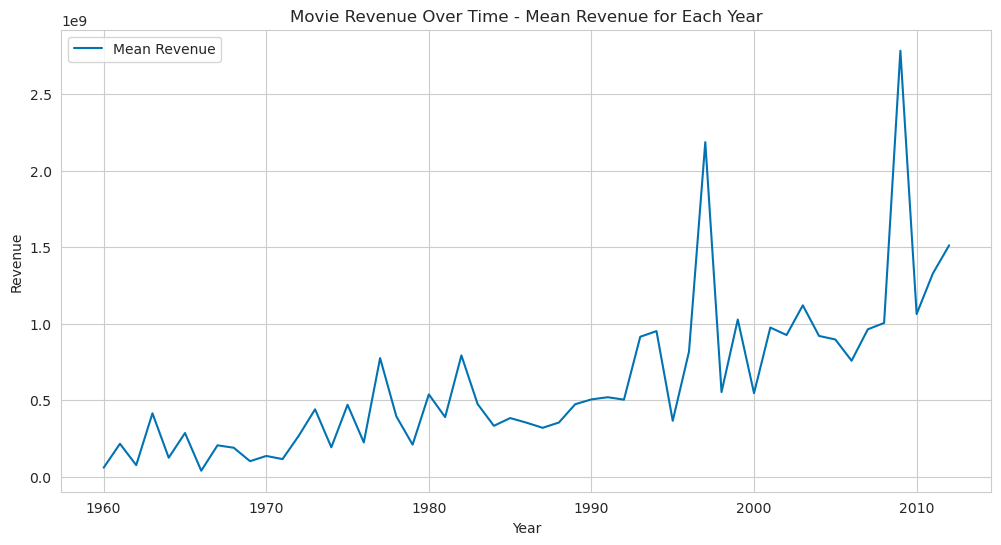

In [35]:
# plot the mean revenue for each year
mean_revenue = movies.groupby(pd.to_datetime(movies["year"]))[["revenue"]].max()

plt.figure(figsize=(12, 6))
plt.plot(mean_revenue.index, mean_revenue["revenue"], label="Mean Revenue")
plt.title("Movie Revenue Over Time - Mean Revenue for Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

As we can see, the mean revenue per year is increasing over time. To accurately compare movie revenues over time, we need to account for inflation. Without this adjustment, comparing movies from different eras becomes misleading. Older movies, which might have been very successful, will seem less profitable due to the lower ticket prices at their time.

The Consumer Price Index is calculated by measuring the price in one period for a fixed basket of consumer goods and services compared to previous periods.

- **Formula**: 
  $$ \text{Adjusted Value} = \left( \frac{\text{Current Value}}{\text{CPI in Current Year}} \right) \times \text{CPI Base Year} $$

- `Current Value`: The original revenue or budget of the movie.
- `CPI in Current Year`: The Consumer Price Index in the year the movie was released.
- `CPI Base Year`: The Consumer Price Index in the base year (2012).


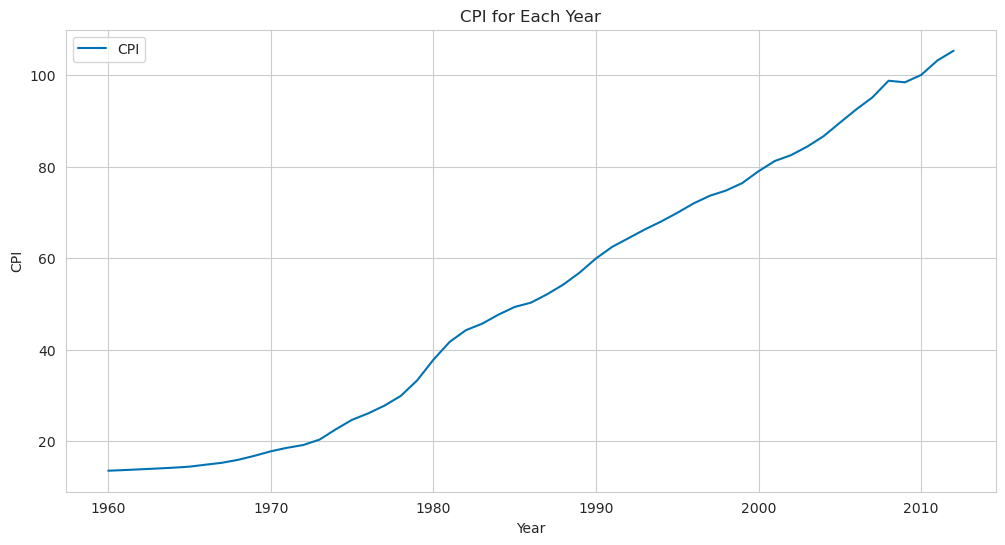

In [36]:
# plot the cpi for each year

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(us_cpi["year"]), us_cpi["cpi"], label="CPI")
plt.title("CPI for Each Year")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.legend()
plt.show()

The graph displays the Consumer Price Index (CPI) for each year, showing an upward trend from 1960 through until 2012.

We'll add two new columns to the dataset, one for the revenue adjusted for inflation and one for the budget adjusted for inflation.

In [37]:
# as our base year we choose 2012
cpi_base_year = us_cpi[us_cpi["year"] == "2012"]["cpi"].values[0]

# merge the movies dataset with the us_inflation dataset on the year column
movies = pd.merge(movies, us_cpi, on="year", how="left")

# calculate adjusted revenue and budget according to the formula
movies["revenue_adjusted"] = (movies["revenue"] / movies["cpi"]) * cpi_base_year
movies["budget_adjusted"] = (movies["budget"] / movies["cpi"]) * cpi_base_year

- When adjusted for inflation, how does the gross revenue of older movies compare to recent modern movies?

We'll plot the original revenue and the inflation-adjusted revenue over time, in order to see the difference.

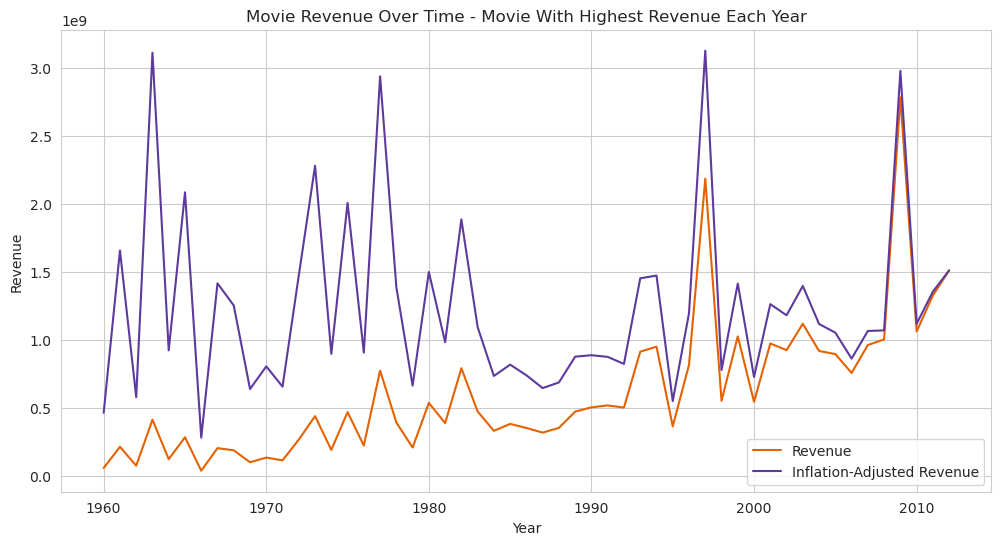

In [38]:
# group by year and get the movie with max revenue and revenue_inflation
annual_revenue = movies.groupby(pd.to_datetime(movies["year"]))[
    ["revenue", "revenue_adjusted"]
].max()

plt.figure(figsize=(12, 6))

plt.plot(
    annual_revenue.index,
    annual_revenue["revenue"],
    label="Revenue",
    color="#E66100",
)
plt.plot(
    annual_revenue.index,
    annual_revenue["revenue_adjusted"],
    label="Inflation-Adjusted Revenue",
    color="#5D3A9B",
)

plt.title("Movie Revenue Over Time - Movie With Highest Revenue Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

From the plot we can see the revenues of the highest-grossing movie of each year with their inflation-adjusted equivalents. 
As we expected,  the inflation-adjusted revenues are higher than the reported revenues as the value of money decreases over time due to inflation. We can also see that the impact of inflation is more pronounced in earlier decades, as seen by the greater distance between the two lines.

After adjusting the revenue for inflation, the peaks in the revenue trends become more pronounced. We can see that some older movies actually have higher inflation-adjusted revenues than newer ones, which wouldn't be apparent if we only looked at nominal revenues.

In [39]:
top_movies = movies.sort_values(by=["revenue_adjusted"], ascending=False).head(5)
top_movies = top_movies[["title", "year", "revenue", "revenue_adjusted"]]
top_movies

,title,year,revenue,revenue_adjusted
1990,Titanic,1997,2.185372e+09,3.125832e+09
637,Love with the Proper Stranger,1963,4.150049e+08,3.111268e+09
2132,Avatar,2009,2.782275e+09,2.977544e+09
7103,Star Wars Episode IV: A New Hope,1977,7.753980e+08,2.937330e+09
2122,The Exorcist,1973,4.410710e+08,2.280793e+09


The movie with the highest nominal revenue is Avatar from 2009, with a revenue of approximately \\$ 2.782 billion. However, when we adjust for inflation, Titanic from 1997 shows a greater revenue than Avatar - an adjusted revenue of approximately \\$ 3.126 billion, compared to Avatar's adjusted revenue of about \\$ 2.978 billion.

Now we want to see if 'older' movies have a higher revenue than 'newer' movies. We define 'older' movies as movies that were released before 2000 and 'newer' movies as movies that were released after 2000.

In [40]:
old_movies_revenues = movies[movies["year"].astype(int) < 2000]["revenue_adjusted"]
new_movies_revenues = movies[movies["year"].astype(int) >= 2000]["revenue_adjusted"]

print("Number of movies before 2000: ", len(old_movies_revenues))
print("Number of movies after 2000: ", len(new_movies_revenues))

Number of movies before 2000:  3551
Number of movies after 2000:  3641


In order to determine this, we first need to check if the data is normally distributed in order to choose the right test. We can do this by plotting a histogram and a Q-Q plot.

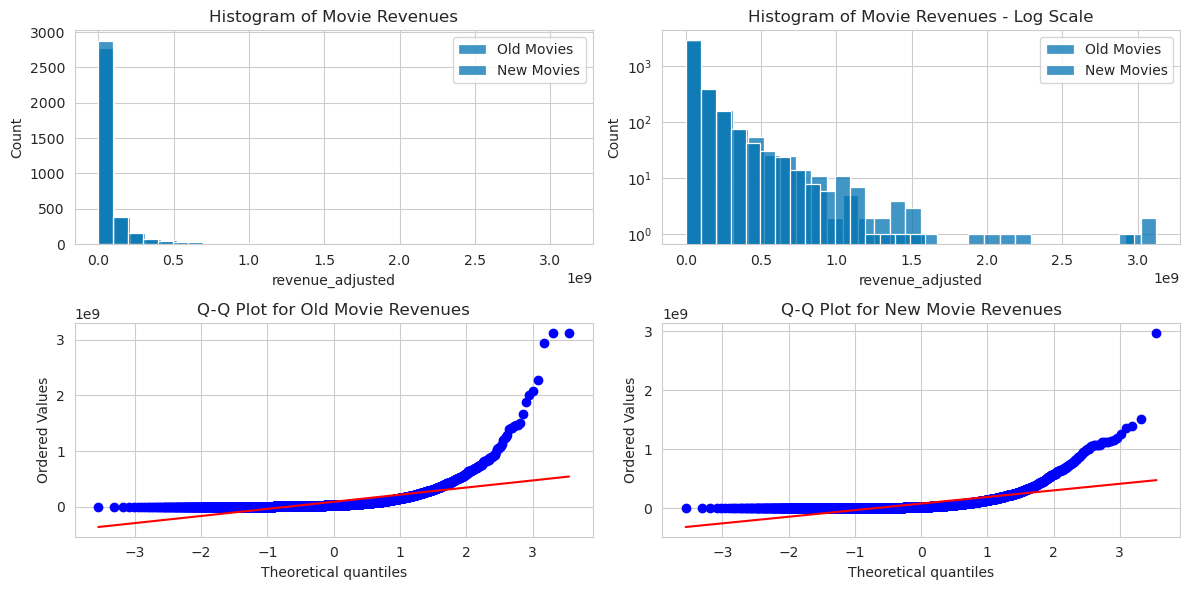

In [41]:
plt.figure(figsize=(12, 6))

# histogram
plt.subplot(2, 2, 1)
sns.histplot(old_movies_revenues, bins=30, kde=False, label="Old Movies")
sns.histplot(new_movies_revenues, bins=30, kde=False, label="New Movies")
plt.legend()
plt.title("Histogram of Movie Revenues")

# histogram with log scale
plt.subplot(2, 2, 2)
sns.histplot(old_movies_revenues, bins=30, kde=False, label="Old Movies")
sns.histplot(new_movies_revenues, bins=30, kde=False, label="New Movies")
plt.yscale("log")
plt.legend()
plt.title("Histogram of Movie Revenues - Log Scale")

# Q-Q plot for old movies
plt.subplot(2, 2, 3)
stats.probplot(old_movies_revenues, dist="norm", plot=plt)
plt.title("Q-Q Plot for Old Movie Revenues")

# Q-Q plot for new movies
plt.subplot(2, 2, 4)
stats.probplot(new_movies_revenues, dist="norm", plot=plt)
plt.title("Q-Q Plot for New Movie Revenues")

plt.tight_layout()
plt.show()

From the histogram we can see that the distribution of the revenues for both groups is not normal. Additionaly, the Q-Q plots which are used to assess how closely the data follows a normal distribution, show that the data is not normally distributed. 

Because of this, we will use the Mann-Whitney U test. The null hypothesis is that there is no significant difference in median revenues between older and newer movies, while the alternative hypothesis is that there is a significant difference. In this analysis, we will use a 0.05 level of significance. This means that if our p-value is less than 0.05, we will reject the null hypothesis and accept the alternative hypothesis.

In [42]:
median_revenue_old = old_movies_revenues.median()
median_revenue_new = new_movies_revenues.median()

# perform a Mann-Whitney U Test to see if there is a difference between the median revenues of old movies and new movies
res = mannwhitneyu(old_movies_revenues.values, new_movies_revenues.values)
print("Mann-Whitney U test: \n statistic =", res.statistic, "\n p =", res.pvalue)
print(
    "Median revenue for older movies =",
    "{:.3f}".format(median_revenue_old),
    "\nMedian revenue for newer movies =",
    "{:.3f}".format(median_revenue_new),
)

Mann-Whitney U test: 
 statistic = 7220205.0 
 p = 9.230451138874896e-18
Median revenue for older movies = 28111512.427 
Median revenue for newer movies = 19323866.660


The p-value is less than 0.05, indicating that there is a statistically significant difference between the median revenues of older movies (released before the year 2000) and newer movies (released in or after the year 2000). Given the median revenues, we can conclude that older movies have a significantly higher median revenue than newer movies when adjusted for inflation.

### Is there a notable trend in the budget of movies over the years when considering inflation?

We can plot the original budget and the inflation-adjusted budget over time, in order to see the difference.

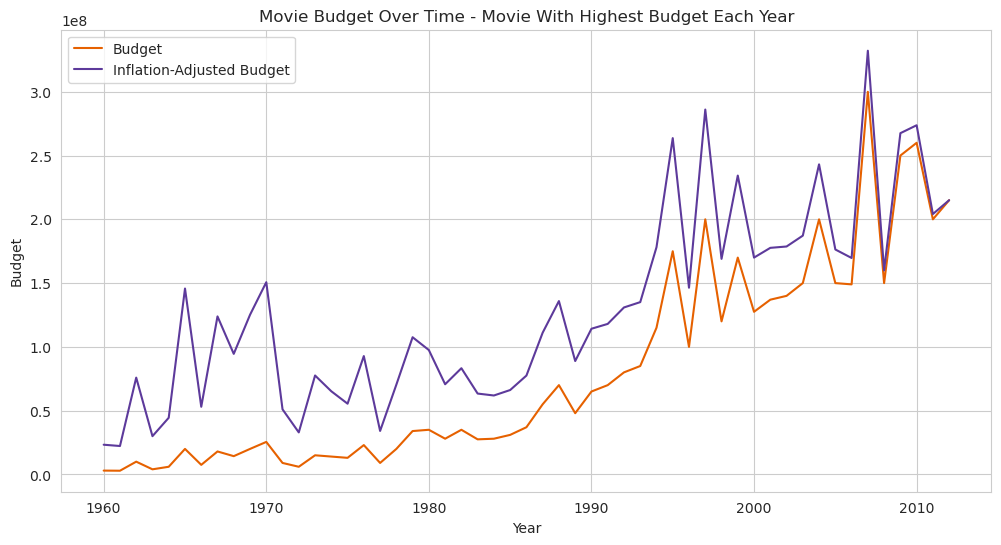

In [43]:
# group by year and get the movie with max budget and revenue_inflation
annual_revenue = movies.groupby(pd.to_datetime(movies["year"]))[
    ["budget", "budget_adjusted"]
].max()

plt.figure(figsize=(12, 6))

plt.plot(
    annual_revenue.index,
    annual_revenue["budget"],
    label="Budget",
    color="#E66100",
)

plt.plot(
    annual_revenue.index,
    annual_revenue["budget_adjusted"],
    label="Inflation-Adjusted Budget",
    color="#5D3A9B",
)

plt.title("Movie Budget Over Time - Movie With Highest Budget Each Year")
plt.xlabel("Year")
plt.ylabel("Budget")
plt.legend()
plt.show()

Again as expected, the inflation-adjusted budgets are consistently higher than the nominal budgets, illustrating the impact of inflation over time. Both the nominal and inflation-adjusted budget lines show an overall upward trend, indicating that the budgets for the high-budget movies per year have been increasing over the decades.

We'll do a Pearson correlation between the inflation-adjusted budget and year to see if there is actually a correlation between the two.

In [44]:
movies_with_budget = movies.dropna(subset=["budget_adjusted"])
pearson_corr_coefficient, p_value = stats.pearsonr(
    movies_with_budget["year"].astype(float),
    movies_with_budget["budget_adjusted"],
)

print(f"Pearson's correlation coefficient: {pearson_corr_coefficient}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: 0.13043034760366937
P-value: 4.633704347063562e-08


The weak positive correlation coefficient and the low p-value suggest a statistically significant, yet not strong, linear relationship between the movie's release year and its inflation-adjusted budget.

The overall upward trend in both nominal and inflation-adjusted movie budgets could be related to broader economic growth, such as increases in GDP. As the economy grows, the movie industry seems to grow with it. We will explore this in the following section.

## Q2: Global Economic Growth and its Influence on the Movie Industry 

### What is the relationship between global economic indicators (like GDP) and movie's gross revenue? 

In [45]:
display(us_gdp.head())

,year,gdp
0,1960,5.433000e+11
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11


### Are there regional differences?

To be done for P3!

---

## Q3: Determinants of a Movie's Financial Success 
### How do factors like budget, runtime, and movie ratings impact the movie's revenue or profitability?


People find it easy to distinguish between a low-budget and a high-budget movie. However, this does not imply that a movie with a high budget will be successful, as many factors contribute to a movie's financial success. In this section, we will briefly explore the relationship between a movie's budget and its revenue, as well as introduce the concept of movie profit and the rate of return on investment.

### Budget and Revenue

The first concept we will try to explore is whether budget and revenue are correlated. We expect that if more money is invested in the movie's production, it will generate more revenue.

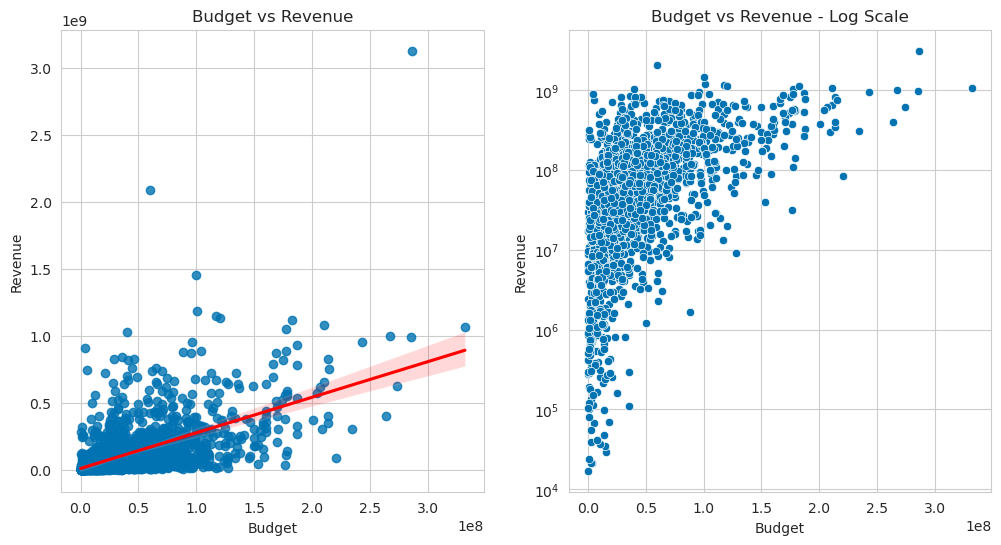

In [62]:
# plotting budget and revenue with a linear y scale (left) and log y scale (right)
# linear regression line is also shown on the left plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(
    ax=axes[0],
    data=movies_with_budget,
    x="budget_adjusted",
    y="revenue_adjusted",
    line_kws={"color": "red"},
)
sns.scatterplot(
    ax=axes[1],
    data=movies_with_budget,
    x="budget_adjusted",
    y="revenue_adjusted",
)
axes[1].set_yscale("log")
axes[0].set_title("Budget vs Revenue")
axes[1].set_title("Budget vs Revenue - Log Scale")
axes[0].set_xlabel("Budget")
axes[0].set_ylabel("Revenue")
axes[1].set_xlabel("Budget")
axes[1].set_ylabel("Revenue")
plt.show()

On a first glance, by observing the blue dots on the left linear-axis plot, it cannot be clearly shown whether putting more money into the movie will generate a higher return. It seems as if most of the movies are lower and upper bounded by some value for budget and revenue, making the scatter plot dense. In order to possibly reveal the true relationship between the two variables we do the following:

1. Plotting a regression line reveals a positive relationship between budget and revenue. That is, the more budget is given for a movie, the more revenue it's expected to achieve.
2. This is also more evidently visible by displaying the revenue on a logarithmic y-scale (right plot) where the higher the budget is, the higher the lower bound is for the corresponding revenue.

Additionally, we perform a Pearson and Spearman statistics test in order to certainly quantify the relationship between budget and revenue.

In [63]:
# check correlation between budget and revenue with pearson and spearman
print(
    "Pearson Correlation: ",
    stats.pearsonr(
        movies_with_budget["budget_adjusted"],
        movies_with_budget["revenue_adjusted"],
    ),
)
print(
    "Spearman Correlation: ",
    stats.spearmanr(
        movies_with_budget["budget_adjusted"],
        movies_with_budget["revenue_adjusted"],
    ),
)

Pearson Correlation:  PearsonRResult(statistic=0.5706510359479671, pvalue=3.74495474048541e-151)
Spearman Correlation:  SignificanceResult(statistic=0.6010321314073527, pvalue=1.1190326937062103e-171)


It is now clearly evident from the p-value smaller than 0.05, that budget and revenue are significantly positiviely correlated with a coefficient of ~ 0.6. We can therefore argue that a movie's revenue value is unlikely to have occured by random chance alone, and is likely tied to the budget.

### Profit

Most of the time, the real financial performance of a movie is measured by its profit. That is, the difference between revenue and budget:


<center> $ profit := revenue - budget $ </center>

We are aware that the movie's profit is dependent on other factors such as social media, merchandise sales and streaming rights, which can also influence its overall financial success. However, since we dont have the data for all of that, we will calculate the profit as the difference between revenue and budget.

This implies that a certain movie could either make profit (if revenue > budget), or loss (if revenue < budget). We start by discovering the top 5 movies that fall into each category and capture some interesting observations.



Which 5 movies made the most and the least profit? Could it happen that some movies even made a loss?

In [64]:
movies["profit"] = movies["revenue_adjusted"] - movies["budget_adjusted"]
display(
    movies.sort_values(by=["profit"], ascending=False).head(5)[
        ["title", "year", "profit", "imdb_rating"]
    ]
)
print(
    "Number of movies that made profit: ",
    len(movies[movies["profit"] > 0]),
)
display(
    movies.sort_values(by=["profit"], ascending=True).head(5)[
        ["title", "year", "profit", "imdb_rating"]
    ]
)
print("Number of movies that made loss: ", len(movies[movies["profit"] < 0]))

,title,year,profit,imdb_rating
1990,Titanic,1997,2.839764e+09,7.9
3876,The Sound of Music,1965,2.025826e+09,8.1
5540,Jurassic Park,1993,1.353630e+09,8.2
749,The Lord of the Rings: The Two Towers,2002,1.081178e+09,8.8
1185,Finding Nemo,2003,1.032297e+09,8.2


Number of movies that made profit:  1209


,title,year,profit,imdb_rating
5293,The Alamo,2004,-1.448673e+08,6.0
3452,The 13th Warrior,1999,-1.354905e+08,6.6
4335,The Adventures of Pluto Nash,2002,-1.185783e+08,3.9
6693,Mars Needs Moms,2011,-1.133044e+08,5.4
2615,Town & Country,2001,-1.032495e+08,4.5


Number of movies that made loss:  527


Almost everyone has heard of the top 5 highest grossing movies (available in our dataset). These are the movies that gained an enormous and exceptional revenue compared to its budget and to the revenue gained by the other movies. Contradictingly, the movies that made a loss are less known and are significantly underperforming in terms of profit when compared to other movies.

It is also interesting to see that the average IMDB rating of the top 5 movies is 8.36 and for the worst 5 movies is 5.28. However, this is also an analysis topic to dig into deeper and these ratings are at this point shown only for illustrative purposes.

Furthermore, it is left as an open question to discuss and claim why a certain movie might make a loss. We had shown before that budget and revenue are moderatily positively related, but we cannot predict a movie's revenue solely based on the given budget. This raises the potential issue of having further confounders (in addition to the budget) affecting the movie's revenue, and therefore its profit. However, this is intuitevely clear to us as movie watchers as we know many factors, such as its genre or actors, could contribute to a movie's success. Later on in the analysis, we try to detangle possible confounders and clearly detect all variables that affect the movie's profit.

<b> Fun fact: </b> The movies that lost money are called <u>box office bombs</u>!

How has the trend of profit changed over time? Should we expect to see more movies with higher profit in the future?

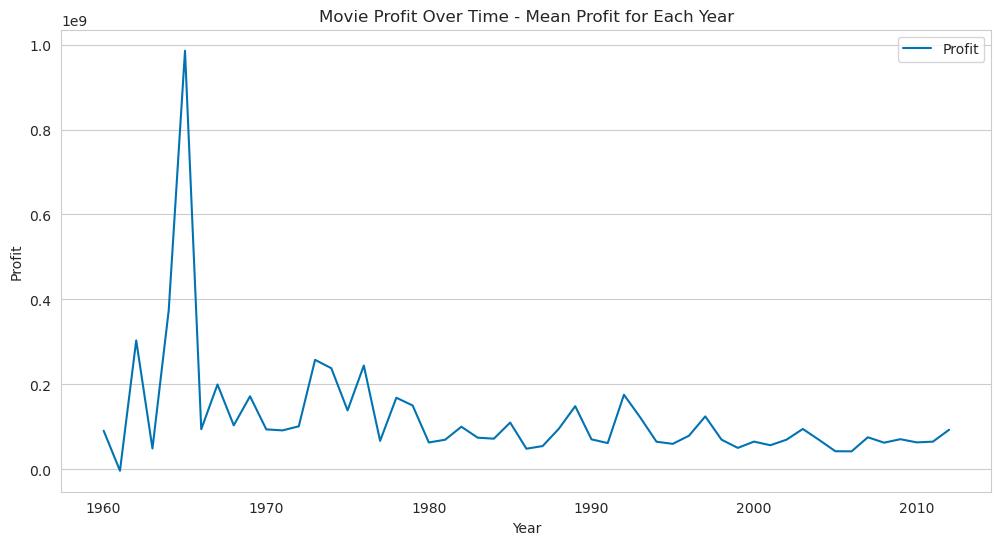

In [65]:
# plot the profit of movies over time
plt.figure(figsize=(12, 6))
plt.plot(
    movies.groupby(pd.to_datetime(movies["year"]))["profit"].mean(),
    label="Profit",
)
plt.title("Movie Profit Over Time - Mean Profit for Each Year")
plt.xlabel("Year")
plt.yscale("linear")
plt.ylabel("Profit")
plt.legend()
plt.grid(axis="x")
plt.show()

Looking at the plot we can see that the mean profit of movies over time is somewhat similar and is upper/lower bounded, with some years performing better or worse than other ones. However, we can see that the mean profit of movies is slightly decreasing over time and varies less. These are the years with highest and lowest mean profit:

In [66]:
# create a list storing the profit for each year
profit_per_year = []
for year in movies["year"].unique():
    profit_per_year.append(movies[movies["year"] == year]["profit"].mean())

# year with the highest and lowest profit
print(
    "Year with highest profit: ",
    movies["year"].unique()[np.argmax(profit_per_year)],
)
print(
    "Year with lowest profit: ",
    movies["year"].unique()[np.argmin(profit_per_year)],
)

Year with highest profit:  1965
Year with lowest profit:  1961


In order to precisely determine the impact of the year on profit, we perform a one-way ANOVA test to check if the mean profit of movies is the same for all years ($H_0$). This would show whether there exists a significant difference in the mean profit of movies for different years.

In [67]:
print(stats.f_oneway(movies["year"].unique(), profit_per_year))
print(stats.spearmanr(movies["year"].unique(), profit_per_year))

F_onewayResult(statistic=40.908131827016746, pvalue=4.6351722914999435e-09)
SignificanceResult(statistic=-0.4546040961135301, pvalue=0.0006270072495625316)


The p-value from the ANOVA test is smaller than 0.05, meaning that we can reject the null hypothesis and accept the alternative that the means are different for different years. Additionally, with the Spearman correlation test we can see that there is a negative correlation between the year and the profit. This means that the profit decreases over time. However, we cannot clearly separate the factors that influence the decrease in profit for now.

What were the chances of a movie making an outstanding profit in the past?

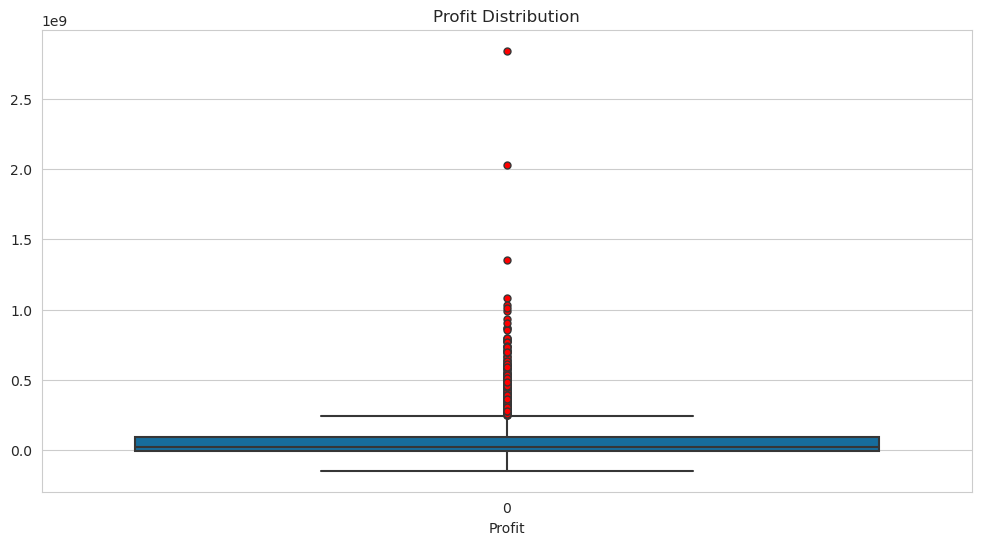

In [68]:
# find movies that made an exceptional profit (outliers)
all_profits = movies[["profit", "budget"]]
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=all_profits["profit"], flierprops=dict(markerfacecolor="r", marker="o")
)
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.yscale("linear")
plt.show()

In this part, we turn to the movie outliers (red points) and try to characterize them. These are the movies that made an exceptional profit (above 95%) and that significantly stand out from the rest of the movies. What were the chances of a movie being an outlier in the past?

In [69]:
# calculate the number of positive outliers in the boxplot distribution
q1 = all_profits["profit"].quantile(0.25)
q3 = all_profits["profit"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)
exceptional_profits = all_profits[all_profits["profit"] > upper_bound]
print("Number of movies with an exceptional profit: ", len(exceptional_profits))
# print chances of movie making exceptional profit formatted in %
print(
    "Chances of a movie making exceptional profit in the past: ",
    "{:.2f}".format(len(exceptional_profits) / len(all_profits) * 100),
    "%",
)

Number of movies with an exceptional profit:  171
Chances of a movie making exceptional profit in the past:  9.81 %


We calculated that a movie had 2.38% chance of making a huge profit. We understand that this is a biased comparisson to the real-world scenario in the movie industry, but we assume that the given dataset is almost equally representative of the real movie data and therefore make this comparisson. It is hard to answer whether a future movie also has a similar chance of making an exceptional profit, but we can assume that the chances are lower than in the past, as the profit overall is decreasing over time (as shown previously).

### Return on Investment (ROI)
Another metric for measuring a movie financial success is ROI. ROI is the percentage of the original investment that was gained or lost. It is calculated as follows:
$$ ROI := \left( \frac{revenue - budget}{budget} \right) \times 100 $$
We can claim that ROI is a more representative metric of the success as it is a relative measure of financial success or failure in terms of percentage of the original investment.

Now, we want to analyze movies that had a high return on investment (ROI). These are the movies that had a high return on investment despite having a possibly low budget. Here are some differences in terms of representing profit and ROI: 
1. Scale: 
    - Profit: real monetary amount gained or lost 
    - ROI: percentage of the original investment that was gained or lost 
2. Direction: 
    - Profit: positive or negative financial gain 
    - ROI: positive or negative percentage of the original investment 
3. Interpretation: 
    - Profit: straightforward absolute measure of financial success or failure in terms of dollars 
    - ROI: relative measure of financial success or failure in terms of percentage of the original investment

In [70]:
# calculate ROI for movies with budget > 0
movies["roi"] = (movies["profit"] / movies["budget_adjusted"]) * 100

# remove inf and NaN rows due to division of zero
movies = movies.replace([np.inf, -np.inf], np.nan)
movies = movies.dropna(subset=["roi"])

# identify top 5 movies with the highest ROI
display(
    movies.sort_values(by=["roi"], ascending=False).head(5)[["title", "year", "roi", "imdb_rating"]]
)

,title,year,roi,imdb_rating
3551,Night of the Living Dead,1968,36742.105263,7.8
4467,Mad Max,1979,24900.000000,6.8
1092,Halloween,1978,23233.333333,7.7
7027,Rocky,1976,22400.000000,8.1
5136,Joe,1970,18125.711321,6.8


We can see these movies are different from the ones that had the highest profit. They have a much lower budget, but a much higher ROI. This means that they had a much higher return on investment, despite having a lower budget, showing that how much you invest in a movie is not the only factor that determines its financial success.

In [71]:
# correlation between profit and roi
print(
    "Pearson Correlation: ",
    stats.pearsonr(movies["profit"], movies["roi"]),
)

Pearson Correlation:  PearsonRResult(statistic=0.23146281706390906, pvalue=1.246601857354523e-22)


Additionally, We can see that there is a weak positive correlation between profit and ROI. This means that the higher the profit, the higher the ROI. However, this correlation is not very strong, so we cannot conclude that the profit is the only factor that determines the ROI.

### Movie Runtime
In this section we dive deeper into the technical aspects of the movie, namely, its runtime measured in terms of minutes. We want to see if there is a relationship between the runtime and the movie's financial success. Is there such thing as the "perfect length" of a movie?

First, we see the general distribution of the runtime of movies in our dataset and calculate the mean and median runtime.

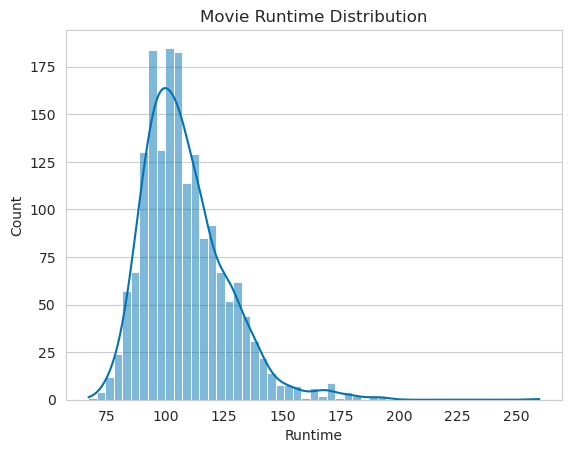

Average movie runtime (minutes):  108 ± 18
Median movie runtime (minutes):  105


In [72]:
# runtime distribution histogram
sns.histplot(data=movies, x="runtime", bins="auto", kde=True)
plt.title("Movie Runtime Distribution")
plt.xlabel("Runtime")
plt.grid(axis="x")
plt.show()

print(
    "Average movie runtime (minutes): ",
    round(movies["runtime"].mean()),
    "\u00B1",
    round(movies["runtime"].std()),
)
print(
    "Median movie runtime (minutes): ",
    round(movies["runtime"].median())
)

It is clear that most of the movies are between the interval [90, 120] minutes, with a mean of 108 and median of 105 minutes. It is obvious that the length has to fall into some 'pre-defined' interval. If the movie is too short, not many people will consider watching it, and if it is too long, people will eventuall lose interest.

Now, we want to see if there is a relationship between the runtime and the movie's financial success. We will plot the runtime vs. budget, revenue, profit and ROI. This way we can see in what movie runtime is the most budget invested, as well as what runtime produces highest revenue, profit and ROI.

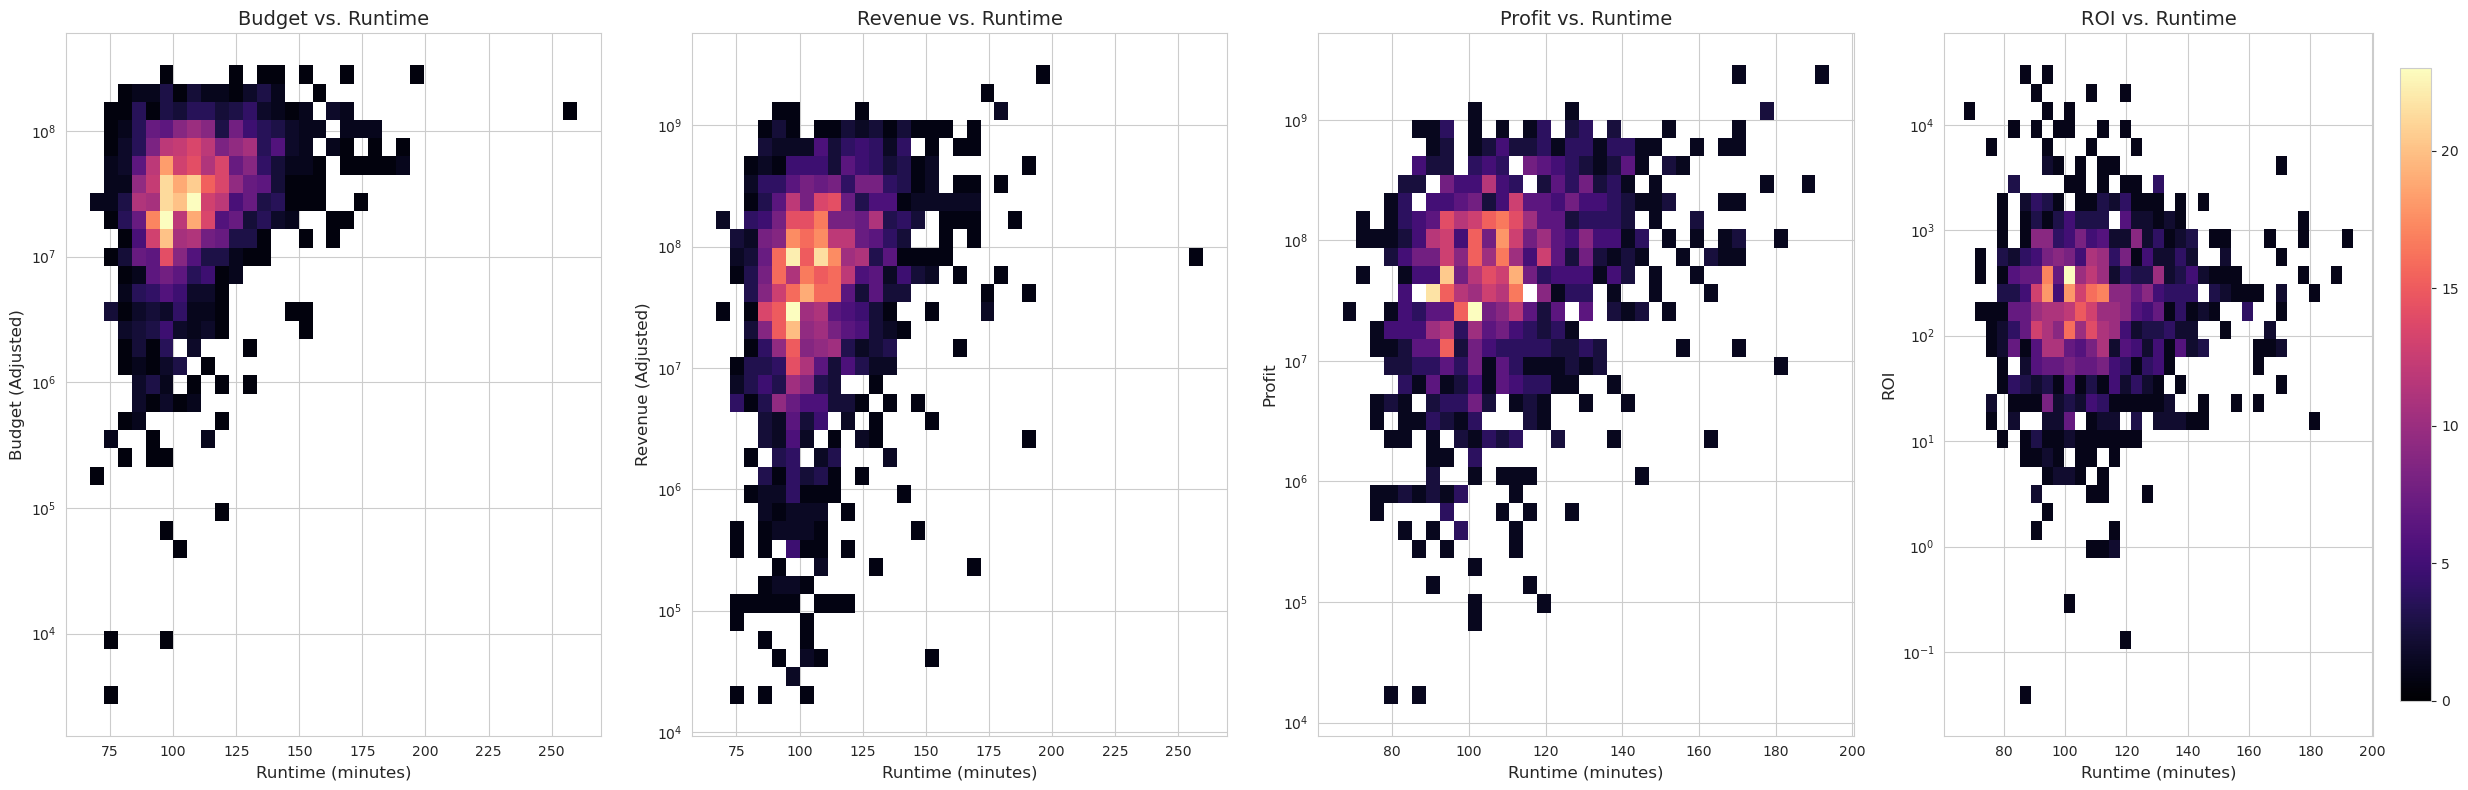

In [82]:
# plot budget, revenue and profit vs. runtime as 2d histograms
fig, axes = plt.subplots(1, 4, figsize=(25, 8))

# Budget vs. Runtime
sns.histplot(
    ax=axes[0],
    data=movies,
    x="runtime",
    y="budget_adjusted",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[0].set_title("Budget vs. Runtime", fontsize=14)
axes[0].set_xlabel("Runtime (minutes)", fontsize=12)
axes[0].set_ylabel("Budget (Adjusted)", fontsize=12)
axes[0].grid(True)

# Revenue vs. Runtime
sns.histplot(
    ax=axes[1],
    data=movies,
    x="runtime",
    y="revenue_adjusted",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[1].set_title("Revenue vs. Runtime", fontsize=14)
axes[1].set_xlabel("Runtime (minutes)", fontsize=12)
axes[1].set_ylabel("Revenue (Adjusted)", fontsize=12)
axes[1].grid(True)

# Profit vs. Runtime
sns.histplot(
    ax=axes[2],
    data=movies[movies["profit"] > 0],
    x="runtime",
    y="profit",
    bins=35,
    cmap="magma",
    log_scale=(False, True),
)
axes[2].set_title("Profit vs. Runtime", fontsize=14)
axes[2].set_xlabel("Runtime (minutes)", fontsize=12)
axes[2].set_ylabel("Profit", fontsize=12)
axes[2].grid(True)

# ROI vs. Runtime
sns.histplot(
    ax=axes[3],
    data=movies[movies["roi"] > 0],
    x="runtime",
    y="roi",
    bins=35,
    cbar=True,
    cbar_kws={"shrink": 0.9},
    cmap="magma",
    log_scale=(False, True),
)
axes[3].set_title("ROI vs. Runtime", fontsize=14)
axes[3].set_xlabel("Runtime (minutes)", fontsize=12)
axes[3].set_ylabel("ROI", fontsize=12)
axes[3].grid(True)

plt.tight_layout()
plt.show()

We can easily connect the initial runtime distribution plot and the following 4 plots. It was shown that the average movie length was in the interval [90, 120], and with these plots we can see that most of the budget, revenue, profit and ROI also fall in this interval. Looking a bit closer into the hue of the 2D histogram plots, we can see that the highest values usually correspond to length of 100 minutes. In order to statistically compare the variables and runtime, we turn to the Spearman correlation test.

In [89]:
# Spearmann correlation between runtime and budget, revenue and profit
print(
    "Spearman Correlation between runtime and budget: ",
    stats.spearmanr(movies["runtime"], movies["budget_adjusted"]),
)
print(
    "Spearman Correlation between runtime and revenue: ",
    stats.spearmanr(movies["runtime"], movies["revenue_adjusted"]),
)
print(
    "Spearman Correlation between runtime and profit: ",
    stats.spearmanr(movies["runtime"], movies["profit"]),
)
print(
    "Spearman Correlation between runtime and ROI: ",
    stats.spearmanr(movies["runtime"], movies["roi"]),
)

Spearman Correlation between runtime and budget:  SignificanceResult(statistic=0.31731757036107716, pvalue=4.5264092153197776e-42)
Spearman Correlation between runtime and revenue:  SignificanceResult(statistic=0.3013580071769405, pvalue=6.398004389404881e-38)
Spearman Correlation between runtime and profit:  SignificanceResult(statistic=0.20218302505785563, pvalue=1.5533541967716372e-17)
Spearman Correlation between runtime and ROI:  SignificanceResult(statistic=0.09567709482064925, pvalue=6.313873827854533e-05)


We will try to characterize each statistical test individually to try to explain the results:
1. **Runtime vs. Budget**
    - We can see that runtime and budget are positively correlated, but with a weak correlation coefficient. Logically, the correlation is positive because the longer the movie is, the more money is needed to produce it. The statistic is not very strong, meaning that the budget is not the only factor that determines the runtime of a movie.
2. **Runtime vs. Revenue**
    - Similarly to the previous test, runtime and revenue are positively correlated, but with a weak correlation coefficient. This means that the longer the movie is, the more revenue it will generate. Since budget and runtime are positively correlated (proven in previous section), it comes by induction that the longer the movies is, the higher the budget, thus, the higher the revenue.
3. **Runtime vs. Profit**
    - Based again on previous analysis it is now clear that the profit will increase as budget and revenue increase accordingly (remind the definition of profit!). Again, the correlation is weak, meaning that the runtime is not the only factor that determines the profit of a movie. 
4. **Runtime vs. ROI**
    - We introdcued ROI specifically for analysis of this kind. As ROI shows real rate of return, we can clearly see that the movie runtime minimally impacts it. This is also evident from the weak correlation coefficient. We can conclude that the runtime is not a statistically significant factor that determines the ROI of a movie.

Thinking about the results, they might seem counter-intuitive. The issue with the first 3 tests is that movie runtime cannot run forever and is upper-bounded. This means that the runtime cannot be arbitrarily large, and therefore the budget, revenue and profit cannot be arbitrarily large. This is why we see a weak correlation between runtime and the other variables. However, ROI is a relative measure and is not upper-bounded and clearly shows that given our dataset, runtime almost does not impact the financial success of a movie.

For example, if we plot again as a scatter plot the relation between runtime and profit, we can see that the correlation is weak, but the trend is linearly and monotonically increasing. This means that the longer the movie is, the higher the profit, technically reaching an infinite value for the profit. However, this is not the case for ROI, as it can be seen on the other plot, which is a nearly stable line.

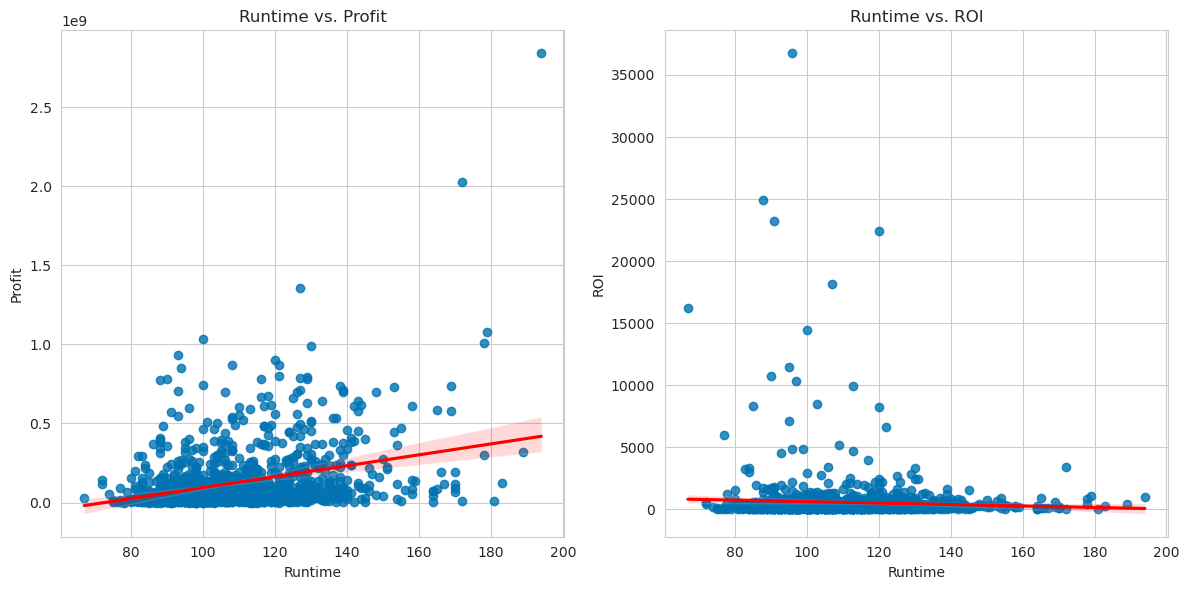

In [94]:
# scatter plot of runtime vs. profit and runtimve vs. roi
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(
    ax=axes[0],
    data=movies[movies["profit"] > 0],
    x="runtime",
    y="profit",
    ci=95,
    line_kws={"color": "red"},
)
sns.regplot(
    ax=axes[1],
    data=movies[movies["roi"] > 0],
    x="runtime",
    y="roi",
    ci=95,
    line_kws={"color": "red"},
)
axes[0].set_title("Runtime vs. Profit")
axes[1].set_title("Runtime vs. ROI")
axes[0].set_xlabel("Runtime")
axes[0].set_ylabel("Profit")
axes[1].set_xlabel("Runtime")
axes[1].set_ylabel("ROI")
plt.tight_layout()
plt.show()


One more way to summarize the above-mentioned comments is to perform a regression task in which we try to estimate the profit of a movie based on its runtime. We will use the Ordinary Least Squares (OLS) method to fit a linear regression model to the data.

In [95]:
# fit a linear regression model for profit vs. runtime
reg = smf.ols(
    formula="profit ~ runtime",
    data=movies,
).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     148.4
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           8.23e-33
Time:                        23:23:37   Log-Likelihood:                -35492.
No. Observations:                1743   AIC:                         7.099e+04
Df Residuals:                    1741   BIC:                         7.100e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.105e+08   2.44e+07     -8.645      0.0

Immediately noticeable is the very small R-squared value of 0.078 which is a good implication that the runtime is not a good predictor of the profit. Based on the comments before regarding ROI, we should expect an even smaller R-squared for the model explaining ROI vs. runtime.

In [101]:
# fit a linear regression model for roi vs. runtime
reg2 = smf.ols(
    formula="roi ~ runtime",
    data=movies,
).fit()
print("R-squared = " + str(reg2.rsquared))

R-squared = 0.001011030435967064


Our personal remark and opinion is that a movie runtime is not specifically chosen to characterize and predict the financial success of a movie. It is rather chosen to fit the movie's plot and storyline and to make it more interesting for the audience and their preference. However, we cannot deny that the runtime is a factor that impacts the financial success of a movie, but it is not the only one and is a very minimal one. We will try to explore other factors in the subsequent sections.

TODO for P3:
- introduce the concept of movie ratings and how they impact the movie's financial success
- analyze whether specific movie runtimes correspond to a range of ratings
- explore how the ratings have changed over time. Are people more critical of movies now than they were in the past?
- and more!

## Q4: Influence of Global Events on the Movie Industry

###  How have significant global events, such as the Global Financial Crisis in 2007-2008, influenced movie budgets and revenues?

## Q5: Correlation Between Movie Content and Financial Success

### Does the frequency of money-related words in movie plot summaries correlate with box office success? Are they more frequent after the Global Financial Crisis?

In [70]:
plots.head()

,wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Q6: Predictive Analysis of Movie Revenue

### Can a regression model using variables like budget, GDP, country, runtime, and release year effectively predict a movie's revenue?